In [21]:
include("../code/sp.jl")
include("../code/matrix_generator.jl")
include("../code/slim_graphs.jl")
include("../code/bp.jl")
using ProgressMeter, StaticArrays, OffsetArrays, Statistics

In [16]:
callback(t, ε, sp) = (println("$t $ε"); false)

function decimate!(sp, indep; decsteps=10, callback=callback)
    H = sp.H
    freevars = copy(indep)
    iteration!(sp, maxiter=700, tol=1e-5, callback=callback, damp=0.5)
    sp_pre = deepcopy(sp)
    while !isempty(freevars)
        iteration!(sp, maxiter=100, tol=1e-3, damp=0.5)
        mag = map(p->p'eachindex(p), sp.survey)
        sort!(freevars, by=i->abs(mag[i]))
        freevars, tofix = freevars[1:end-decsteps], freevars[max(1,end-decsteps+1):end]
#         println("fixing: $tofix")
        sp.efield[tofix] .= sp.J.*sign.(mag[tofix])
#         x = Vector(mag .< 0)
#         x1 = (B*x[indep]) .% 2
#         println("$(sum(H*x .%2)) $(sum(x .!= x0)/length(x)) $(sum(x1 .!= x0)/length(x)) $(length(freevars)/length(indep))")
    end
    sp_pre
end

decimate! (generic function with 2 methods)

In [43]:
f1 = 0.01
f3s = 0.3:0.05:0.6
# f3s = [0.3]
Rs = fill(NaN, eachindex(f3s))
D_sp = fill(NaN, eachindex(f3s))
y = 0.5
n = 4200
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
J = 20
compl = zeros(length(f3s))
sps_pre = Vector{SurveyPropagation{Bool, OffsetVector{Float64, Vector{Float64}}}}(undef, length(f3s));
sps_post = Vector{SurveyPropagation{Bool, OffsetVector{Float64, Vector{Float64}}}}(undef, length(f3s));

In [44]:
for (i,f3) in pairs(f3s)
    println("--- degree $i of $(length(f3s)): f3 = $f3 ---")
    flush(stdout)
    Λ = OffsetVector([0,f1,1-f1-f3,f3], 0:3)
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK; Rs[i]=1-α
    # Single instance
    nedges = Int(round(n*sum(i*l for (i,l) in pairs(Λ)), digits=8))
    m = Int(nedges/3)
    Ht = ldpc_matrix(n, m, nedges, Λ, K)
    H = permutedims(Ht)
    B,indep = findbasis_slow(Array(H))
    x0 = bitrand(size(H,2))
    s = (-1) .^ x0
    init = OffsetArray(MVector{2J+1}(fill(0.0,2J+1)), -J:J)
    init[-1:1] .= 1/3
    sp = survey_propagation(H; field=copy(s), init=copy(init), y=y)
    sps_pre[i] = decimate!(sp, indep; decsteps=1, callback=(x...)->false)
    mag = sign.(map(p->p'eachindex(p), sp.survey))
    x = mag .== -1
    w = sparse(B*x[indep] .% 2)
    println("Nunsat = ", sum(H*x .% 2))
    D_sp[i] = mean(w .!= x0)
    sps_post[i] = sp
    compl[i] = overlap(sps_pre[i])[3]
end

--- degree 1 of 7: f3 = 0.3 ---
Nunsat = 2
--- degree 2 of 7: f3 = 0.35 ---
Nunsat = 10
--- degree 3 of 7: f3 = 0.4 ---
Nunsat = 5
--- degree 4 of 7: f3 = 0.45 ---
Nunsat = 11
--- degree 5 of 7: f3 = 0.5 ---
Nunsat = 13
--- degree 6 of 7: f3 = 0.55 ---
Nunsat = 33
--- degree 7 of 7: f3 = 0.6 ---
Nunsat = 107


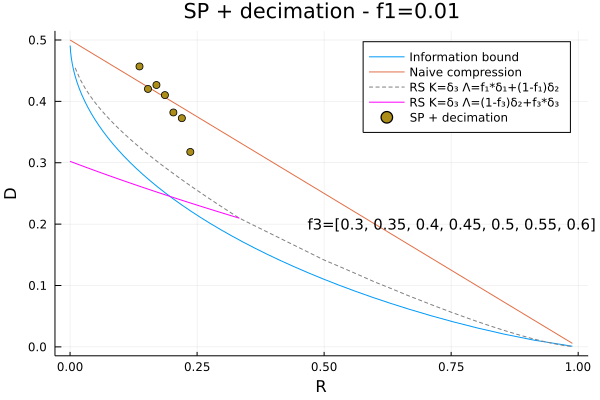

In [45]:
plot_rdb()
scatter!(Rs, D_sp, label="SP + decimation")
annotate!(0.75,0.2,Plots.text("f3="*string(collect(f3s)),10))
title!("SP + decimation - f1=$f1")

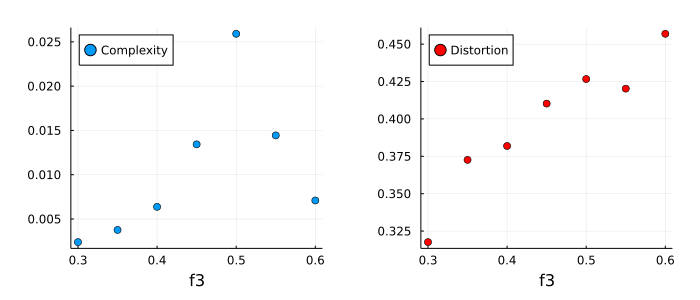

In [48]:
p1 = scatter(f3s, compl, label="Complexity", legend=:topleft, xlabel="f3")
p2 = scatter(f3s, D_sp, c=:red, label="Distortion", legend=:topleft, xlabel="f3")
plot(p1,p2, size=(700,300), margin=5Plots.mm)

In [49]:
n

4200

In [5]:
n = 2100
f1 = 0.01
f3 = 0.4
Λ = OffsetVector([0,f1,1-f1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK; R = 1-α
# Single instance
nedges = Int(round(n*sum(i*l for (i,l) in pairs(Λ)), digits=8))
m = Int(nedges/3)
Ht = ldpc_matrix(n, m, nedges, Λ, K)
H = permutedims(Ht)
B,indep = findbasis(H, Ht)
x0 = bitrand(size(H,2))
s = (-1) .^ x0
J = 20
y = 0.5
init = OffsetArray(MVector{2J+1}(fill(0.0,2J+1)), -J:J)
init[-1:1] .= 1/3
sp = survey_propagation(H; field=copy(s), init, y=y)

SurveyPropagation{Bool, OffsetVector{Float64, Vector{Float64}}}(
⢒⠛⠆⢦⣜⠪⠶⢁⢪⣾⡺⣋⣵⢴⡽⡪⣟⣾⣣⡸⣰⢶⣟⣿⢶⡸⡰⣵⢠⠶⠷⣺⡴⣢⣛⠙⣼⡃⢶⢷
⢈⢿⣽⢯⢬⢿⣹⣿⡻⣻⣾⡦⢱⡣⡯⣞⣽⡺⠘⣣⡸⣝⣯⠏⠵⣷⡹⡃⡗⡺⡿⣯⢬⡝⢗⣾⡰⡴⢭⡛
⢽⣫⣭⢳⣤⠷⣿⣯⣄⡵⣗⢙⡿⣿⣧⠻⠻⣰⡘⣧⢧⡻⣫⡿⠟⢿⠿⠼⣥⡗⣁⠬⣟⣋⣾⡎⣓⣮⣘⡦
⣾⠀⣟⣅⠧⣛⡭⢽⡏⢝⠥⣿⣩⣓⢖⣖⣺⢗⣺⢛⣛⡾⣦⣿⡽⠺⣿⡜⠿⡯⡱⠆⣗⡾⣯⡴⣣⣥⢗⡋
⢙⣑⢌⣛⣿⢗⠫⣜⢷⢺⠊⣳⣿⢴⡡⡽⠪⡏⡁⡯⡿⢹⣮⠶⢿⣣⣏⣝⡟⢮⡮⣕⣓⣗⡬⣯⡳⡏⠒⢄
⢱⢠⣊⡶⣾⢻⣮⣧⣼⡗⣷⢝⣾⠦⢾⣹⣽⣯⢕⢨⡒⡉⠻⡆⣶⣾⢟⡼⠿⡮⢩⣖⣧⢜⣼⢏⣽⠯⣾⢇
⣬⡶⠽⣿⡬⡾⣳⣕⣳⢟⣻⡋⠍⠵⢟⡮⣟⢱⡫⣹⣑⢦⣷⣒⣿⠓⡘⢖⠶⢭⡺⣺⣮⠻⢧⣞⣻⣯⣜⢦
⢛⢟⣣⠷⣉⣌⣹⡽⣻⢺⢮⢞⣘⡧⡖⡽⢺⢹⠼⣝⣯⣘⢿⠺⡞⡩⢐⣷⠵⣿⢦⡥⣻⣻⡺⡮⢳⣵⣯⡛
⣞⣿⡕⣻⣷⡗⡭⢹⡻⠭⢟⢟⣧⣿⣩⣐⣗⠞⣾⣵⣝⣻⠎⢕⠫⣧⣱⠷⢩⣤⣼⢋⢯⢟⣦⡝⡋⣶⡵⣡
⢈⣿⢏⢊⡕⣸⡠⡦⡿⣯⣻⣣⠞⣯⣩⣧⠌⣺⣜⠅⢝⣱⢳⠻⠞⣷⢯⣳⣹⡯⣣⠗⠿⣳⡠⠞⣾⡯⣵⣕
⢅⣲⡯⣭⣪⡹⡢⣟⡔⡎⢹⡞⠾⣗⣵⡺⣎⡃⣽⡾⣟⢣⢝⢧⢭⣿⣣⣻⡽⣯⢊⡿⠮⣖⡴⡛⣽⣈⠺⠟
⢖⡼⢱⠺⡶⢍⡻⣟⠇⣅⡦⣌⠯⣗⣓⣴⣿⣾⣲⣶⢜⣟⢏⢛⠻⢯⠹⣜⢻⣮⣏⣻⢝⠒⢄⡱⡟⢏⣞⠏
⢔⠑⠯⠯⠃⣯⢴⢬⣟⡴⡡⣪⣩⣯⣸⢖⡾⡳⣇⢙⡷⣿⣪⣿⣬⢶⣟⡝⣻⣟⣋⢶⣱⢴⡽⡻⠦⢆⠗⣽
⢝⣻⣷⡶⡟⡗⣃⠦⠑⡪⢓⣷⣿⢦⣵⢷⢗⢕⣫⣞⢟⡴⣍⢕⢟⣲⣿⣹⠺⣟⡉⣫⣶⡼⢘⣭⠭⣶⣳⢿
⡿⡽⡯⢯⢹⣃⣥⢋⠾⡹⡺⡋⣮⢪⣯⣛⣨⣗⡝⡒⣯⠬⡆⡼⣧⠿⣷⢎⣷⣾⢞⣸⢋⢣⣺⣚⣺⢾⣧⠇
⠻⠉⠻⠙⠪⠗⠾⠋⠶⠐⠚⠛⠈⠃⠲⠒⠙⠴⠫⠱⠻⠟⠽⠚⠝⠻⠓⠳⠛⠯⠙⠜⠛⠾⠻⠜⠏⠑⠋⠶, 
⣰⠁⢒⢠⠤⡅⠞⡆⠞⠢⣇⠂⠮⠐⠔⠆⡼⣜⣷⠡⢔⣧⣓⣢⣤⠆⢌⣒⣘⠬⡦⠊⠡⡵⡔⢮⠣⣎⡖⠕
⠐⡐⢸⡩⠿⢓⣨⢷⢖⣴⠆⡑⡅⡐⣙⣨⠬⡚⡕⡤⡛⠽⠜⠕⠉⣱⢻⣙⢰⡁⡴⣳⠄⢲⠼⡞⢝⠗⢭⠆
⣈⢆⡝⢁⡗⠙⠐⡦⢤⡈⢯⢦⡕⡸⣔⣓⢫⠷⠒⠓⡜⣱⢟⢏⠤⣊⠔⣳⠒⡧⠬⠭⠃⣰⡫⢬⡒⢈⡚⢄
⢨⢐⢩⠗⢇⣱⡹⡰⡺⣑⣲⠋⠼⢛⠧⡹⡭⢫⠄⢈⡎⠇⡑⠶⠦⠶⠬⣔⢆⢉⠬⠃⡶⢋⡇⣒⡐⣹⠹⡖
⠌⠃⢴⡛⣬⡵⢻⣵⣊⣂⣌⢹⡰⠵⠭⠒⠼⢍⣎⣚⢭⣘⠅⢀⣗⢔⡬⡦⢏⠝⣆⠹⣛⠠⡐⠲⡔⢀⡲⠍
⣐⡕⠮⣗⣪⠄⡸⢷⣕⡕⡺⡟⢂⢤⣽⠪⡣⢞⢡⠒⣝⢴⠈⣗⢏⡄⣌⢰⣙⣞⡠⠍⡹⠨⠄⡐⠾⡧⠔⠎
⡠⣏⡫⣸⣟⡣⡃⢔⢈⡎⠥⠋⢉⣿⡒⣫⡧⣜⠬⡾⠼⠎⠆⣶⡁⡳⡤⣀⠐⢖⡑

In [148]:
decimate!(sp, indep; decsteps=1)

In [149]:
mag = sign.(map(p->p'eachindex(p), sp.survey))
x = mag .== -1
w = sparse(B*x[indep] .% 2);

In [150]:
dist = mean(w .!= x0)
R, dist

(0.20333333333333325, 0.2661904761904762)

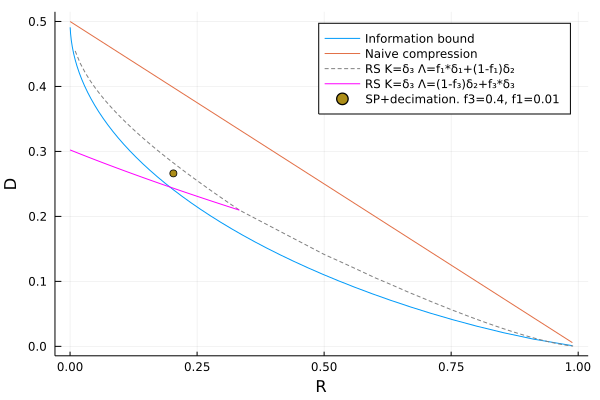

In [151]:
plot_rdb()
scatter!([R], [dist], label="SP+decimation. f3=$f3, f1=$f1")

In [219]:
function callback(t, ε, sp)
    t % 10 != 0 && return false
    mag = map(p->p'sign.(eachindex(p)), sp.survey)
    x = Vector(mag .< 0)
    x1 = (B*x[indep]) .% 2
    check = sum(H*x .%2)
    println("$t $check $(sum(x .!= x0)/length(x)) $(sum(x1 .!= x0)/length(x))")
    return check == 0
end
iteration!(sp, maxiter=100000, tol=1e-5, damp=0.2, rein=0.1, callback=callback)

10 281 0.202 0.2833333333333333
20 262 0.20477777777777778 0.27844444444444444
30 236 0.20666666666666667 0.2713333333333333
40 239 0.207 0.27444444444444444
50 215 0.20966666666666667 0.27155555555555555
60 207 0.21 0.27044444444444443
70 199 0.21166666666666667 0.2728888888888889
80 188 0.21244444444444444 0.2693333333333333
90 167 0.21266666666666667 0.27055555555555555
100 170 0.21222222222222223 0.27255555555555555
110 165 0.2127777777777778 0.2688888888888889
120 160 0.2137777777777778 0.2703333333333333
130 142 0.21555555555555556 0.26944444444444443
140 140 0.21544444444444444 0.2653333333333333
150 133 0.21644444444444444 0.2657777777777778
160 133 0.21755555555555556 0.2598888888888889
170 111 0.219 0.259
180 97 0.22022222222222224 0.25733333333333336
190 77 0.2212222222222222 0.25266666666666665
200 77 0.22155555555555556 0.24988888888888888
210 62 0.22233333333333333 0.247
220 73 0.222 0.24855555555555556
230 72 0.22211111111111112 0.2511111111111111
240 67 0.223 0.25111111

In [206]:
mag = map(p->p'eachindex(p), sp.survey);
x = Vector(mag .< 0)
xbase = B*(x[indep]) .% 2;

In [207]:
all(sign.(mag[indep]) == sign.(sp.efield[indep])) 

false

In [208]:
@show sum(x .!= x0)/length(xbase) 
@show sum(H*x .% 2)
@show sum(xbase .!= x0)/length(xbase)
@show sum(H*xbase .%2)/size(H,1)

sum(x .!= x0) / length(xbase) = 0.2058888888888889
sum((H * x) .% 2) = 235
sum(xbase .!= x0) / length(xbase) = 0.26766666666666666
sum((H * xbase) .% 2) / size(H, 1) = 0.0


0.0

In [209]:
sum(p[begin] for p in sp.survey)

2.2417460331495522e-69

In [128]:
[p[[-sp.J,sp.J]] for p in sp.survey[indep]]

2405-element Vector{Vector{Float64}}:
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 1.0]
 ⋮
 [1.0, 0.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]

In [27]:
using ProgressMeter
callback(t,fg) = nothing;#println("$t $(fg.belief[1:4])")

nsamples = 10
fg = maxsum(H,  1 .- 2y .+ 1e-8*randn(N));

# the mapping is (0,1)=>(1,-1)
dist = map(1:nsamples) do i
    y = rand((0,1), N)
    fg.M .= 0
    fg.efield .= 1 .- 2y .+ 1e-8*randn(N)
    iteration!(fg; maxiter=2000, γ=1e-3, callback=callback)
    x = Int.(fg.belief .< 0)
    c = sum(fg.H'x .% 2)
    d = sum(x .⊻ y)/N
    @show d c
    x1 = B*x[indep] .% 2; d1 = sum(x1 .⊻ y)/N; c1 = sum(fg.H'x1 .% 2); @show d1 c1 
    d1
end
sum(dist)/nsamples

LoadError: UndefVarError: y not defined

In [28]:
1-M/N,sum(dist)/nsamples

LoadError: UndefVarError: dist not defined

In [29]:
x=[1:10;]; f=(x .% 2 .== 1);x[findall(f)]==x[f]

true

In [52]:
dist = map(1:10) do i
    Random.seed!(i)
    
    y = rand((0,1), N)

    lm = LossyModelGF2(fg, zeros(N), Inf, 1.0, y)
    
    function checker()
        v = (B*((fg.fields .< 0)[indep])) .% 2;
        dist = sum(v .⊻ y)/N
        check = sum(H*(fg.fields .< 0) .% 2)
        check, dist
    end

    independent = falses(N)
    independent[indep] .= true
    res_fg = solve!(lm, fg, randseed=1, verbose=true, showprogress=true, 
        independent=independent, basis = B)
#    res_fg = solve!(lm, fg, randseed=1, verbose=true, showprogress=true)
    avg_dist = res_fg.distortion 
    check, dist = checker()
    @show dist check avg_dist
    dist
end

Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.24287749287749288
check = 1
avg_dist = 0.4309116809116809


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.24786324786324787
check = 1
avg_dist = 0.4309116809116809


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.25427350427350426
check = 1
avg_dist = 0.4537037037037037


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.26495726495726496
check = 5
avg_dist = 0.4565527065527066


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.2378917378917379
check = 1
avg_dist = 0.42592592592592593


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.26851851851851855
check = 4
avg_dist = 0.4423076923076923


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.245014245014245
check = 6
avg_dist = 0.4458689458689459
dist = 0.24715099715099714
check = 0
avg_dist = 0.24715099715099714


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.25427350427350426
check = 2
avg_dist = 0.44515669515669515
dist = 0.24857549857549857
check = 0
avg_dist = 0.24857549857549857


10-element Vector{Float64}:
 0.24287749287749288
 0.24786324786324787
 0.25427350427350426
 0.26495726495726496
 0.2378917378917379
 0.26851851851851855
 0.245014245014245
 0.24715099715099714
 0.25427350427350426
 0.24857549857549857

In [53]:
dev = sqrt(sum(dist.^2)/length(dist)-(sum(dist)/length(dist))^2)/sqrt(length(dist))
1-M/N, sum(dist)/length(dist)

(0.24002849002849003, 0.2511396011396011)